# Using document vectors to predict discourse element labels in argumentative student essays

- [x] Do word2vec first into matrix/dataframe. Check cosine similarities/semantic similarities of sentences.
- [x] Request COCA preloaded vector matrix

- [x] Get word count: 10,569,558 (raw) - 10,552,942 (elements with 2 or more tokens)
- [x] Lemmatize before creating Vocab [Maybe this helped? Hard to say.]
- [x] For diagnostic purposes: Get 10 or so discourse elements that are clearly similar and verify that the model agrees that they are similar. [Results look pretty good]

- [x] Throw it at an RF Classifier.

- [ ] Combine discourse elements like rebuttal and evidence. Also remove unannotated.
- [ ] Look for classifiers that work well with unbalanced labels. Multinomial Logistic Regression?

- [ ] Think about eventually comparing results with spelling corrected and original versions. Might use neurSpell for this.

## Langdon's thoughts

We may see better results if we include contextual information as well. 

We might try an essay-level document vector as well as a discourse-element-level vector. It should be possible to concatenate or average these vectors in a meaningful way, but I would need to look into the details.

Positional information might also be useful. Again, I'm not sure exactly how this sort of information is embedded into a vector, but I think there are methods available.

## Import statements

In [6]:
import os.path # Directories, gotta have em.
import pickle # Better than .csv + a cute name.
import pandas as pd # DataFrames. Looping is easy. Obscure functions are fast.
import numpy as np # do math on vectors with more obscure functions.
import re # one-way encryption for your codebase
import pathlib
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

# Interactive Computing
from timeit import default_timer as tm
import datetime
from tqdm import tqdm

# Spacy
import spacy
from spacy.tokens import Doc, DocBin
nlp = spacy.load('en_core_web_trf')

if not Doc.has_extension('name'):
    Doc.set_extension('name', default=None)

import gensim

## Exploration

In [2]:
persuade_corpus = pd.read_pickle('persuade_corpus_full.pkl')
display(persuade_corpus.essay_id_comp)

0         423A1CA112E2
1         423A1CA112E2
2         423A1CA112E2
3         423A1CA112E2
4         423A1CA112E2
              ...     
285378    DF920E0A7337
285379    DF920E0A7337
285380    DF920E0A7337
285381    DF920E0A7337
285382    DF920E0A7337
Name: essay_id_comp, Length: 285383, dtype: object

In [3]:
spacy_file = 'persuade.spacy'

def proc_texts(text_tuples):
    doc_bin = DocBin(attrs=["ORTH", "TAG", "HEAD", "DEP", "LEMMA", "MORPH", "POS"], store_user_data=True)
    for doc, name in nlp.pipe(text_tuples, as_tuples=True):
        doc._.trf_data = None
        doc._.name = name
#         doc.cats = {} # I can use this to store categories for spacy text categorization later on.
        doc_bin.add(doc)
    return doc_bin

if os.path.isfile(spacy_file):
    doc_bin = DocBin().from_disk(spacy_file)
else:
    doc_bin = proc_texts(text_id_tuples)
    doc_bin.to_disk(spacy_file)
docs = list(tqdm(doc_bin.get_docs(nlp.vocab), total=len(doc_bin)))

100%|██████████| 285383/285383 [01:23<00:00, 3435.15it/s]


In [17]:
discourse_types = persuade_corpus[['discourse_type']].copy()
print([type for type in discourse_types.value_counts().index.get_level_values(0)])

['Claim', 'Evidence', 'Unannotated', 'Position', 'Concluding Statement', 'Lead', 'Counterclaim', 'Rebuttal']


In [20]:
simple_texts_file = 'simple_texts_with_stops.pkl'

simple_texts = [] # list of lists of strings
for doc in docs:
    new_doc = [t.lemma_ for t in doc if t.is_alpha]
    simple_texts.append(new_doc)

discourse_types['text'] = simple_texts

In [6]:
# for i in range(2,10):
#     print(f'Number of discourse unit labels with {str(i)} or fewer tokens:')
#     display(discourse_types[discourse_types['text'].apply(len) <= i]['discourse_type'].value_counts())
#     print(f'Examples of discourse elements with exactly {str(i)} tokens:')
#     display(discourse_types[(discourse_types['text'].apply(len) == i)]) #& (discourse_types['discourse_type'].str.match('Claim'))][:5])

Number of discourse unit labels with 2 or fewer tokens:


Unannotated             25960
Claim                    1484
Position                   45
Rebuttal                    7
Lead                        4
Counterclaim                3
Evidence                    2
Concluding Statement        1
Name: discourse_type, dtype: int64

Examples of discourse elements with exactly 2 tokens:


,discourse_type,text
28,Unannotated,"[phone, driving]"
188,Unannotated,"[phone, driving]"
213,Unannotated,"[explain, why]"
278,Unannotated,"[because, of]"
295,Unannotated,"[in, conclusion]"
...,...,...
285268,Claim,"[more, experienced]"
285309,Unannotated,"[of, course]"
285332,Claim,"[make, change]"
285366,Unannotated,"[in, conclusion]"


Number of discourse unit labels with 3 or fewer tokens:


Unannotated             28714
Claim                    2731
Position                   99
Rebuttal                   36
Lead                       12
Counterclaim               12
Evidence                    4
Concluding Statement        1
Name: discourse_type, dtype: int64

Examples of discourse elements with exactly 3 tokens:


,discourse_type,text
52,Unannotated,"[phone, and, drive]"
71,Unannotated,"[phone, and, drive]"
90,Claim,"[slow, reaction, time]"
91,Claim,"[and, fatal, injury]"
100,Unannotated,"[texte, and, drive]"
...,...,...
285219,Unannotated,"[another, reason, be]"
285299,Unannotated,"[nd, also, because]"
285305,Unannotated,"[in, my, experience]"
285329,Claim,"[keep, you, safe]"


Number of discourse unit labels with 4 or fewer tokens:


Unannotated             30308
Claim                    4490
Position                  248
Rebuttal                  100
Counterclaim               45
Lead                       24
Evidence                   14
Concluding Statement        7
Name: discourse_type, dtype: int64

Examples of discourse elements with exactly 4 tokens:


,discourse_type,text
13,Claim,"[be, because, bad, wreck]"
15,Claim,"[and, may, cause, death]"
59,Claim,"[it, can, be, illegal]"
62,Unannotated,"[also, good, case, scenario]"
244,Claim,"[it, can, cause, accident]"
...,...,...
285221,Unannotated,"[one, last, reason, be]"
285227,Unannotated,"[the, last, reason, be]"
285251,Unannotated,"[get, different, opinion, can]"
285253,Claim,"[different, type, of, advice]"


Number of discourse unit labels with 5 or fewer tokens:


Unannotated             31646
Claim                    6921
Position                  683
Rebuttal                  206
Counterclaim              120
Lead                       53
Evidence                   39
Concluding Statement       23
Name: discourse_type, dtype: int64

Examples of discourse elements with exactly 5 tokens:


,discourse_type,text
14,Claim,"[put, other, life, in, danger]"
33,Unannotated,"[cell, phone, operation, while, drive]"
57,Claim,"[can, cause, a, car, accident]"
78,Rebuttal,"[and, somehmes, it, be, overrated]"
337,Unannotated,"[not, use, phone, while, drive]"
...,...,...
284960,Claim,"[others, might, have, different, perspective]"
285164,Claim,"[advice, may, be, more, accurate]"
285165,Claim,"[there, will, be, more, option]"
285293,Unannotated,"[nd, to, that, I, say]"


Number of discourse unit labels with 6 or fewer tokens:


Unannotated             32522
Claim                    9676
Position                 1538
Rebuttal                  330
Counterclaim              227
Evidence                  104
Lead                       89
Concluding Statement       58
Name: discourse_type, dtype: int64

Examples of discourse elements with exactly 6 tokens:


,discourse_type,text
89,Claim,"[because, it, can, cause, vehicle, collision]"
147,Claim,"[the, most, detrimental, outcome, be, death]"
191,Claim,"[for, example, it, be, extremely, dangerous]"
342,Claim,"[a, phone, be, a, big, distraction]"
368,Claim,"[you, can, get, in, a, wreck]"
...,...,...
284846,Claim,"[they, often, have, different, life, experint]"
284918,Claim,"[most, of, the, time, majority, win]"
284981,Claim,"[you, can, make, a, well, choice]"
285270,Claim,"[see, the, person, point, of, view]"


Number of discourse unit labels with 7 or fewer tokens:


Unannotated             33366
Claim                   12889
Position                 2453
Rebuttal                  488
Counterclaim              407
Evidence                  178
Lead                      142
Concluding Statement       97
Name: discourse_type, dtype: int64

Examples of discourse elements with exactly 7 tokens:


,discourse_type,text
23,Unannotated,"[drive, while, the, use, of, cellular, device]"
123,Claim,"[you, should, have, any, distraction, while, d..."
145,Claim,"[it, could, lead, to, accident, and, altercation]"
217,Position,"[phone, should, not, be, use, while, drive]"
279,Claim,"[the, many, car, accident, they, be, cause]"
...,...,...
285267,Claim,"[they, can, see, which, advice, be, well]"
285315,Claim,"[they, have, more, experience, compare, to, you]"
285318,Claim,"[give, you, multiple, perspective, to, deliber..."
285358,Claim,"[a, great, chance, to, learn, something, new]"


Number of discourse unit labels with 8 or fewer tokens:


Unannotated             34240
Claim                   16386
Position                 3633
Rebuttal                  654
Counterclaim              629
Evidence                  305
Lead                      240
Concluding Statement      155
Name: discourse_type, dtype: int64

Examples of discourse elements with exactly 8 tokens:


,discourse_type,text
67,Claim,"[drive, while, on, your, phone, can, be, illegal]"
113,Claim,"[they, can, be, severely, injure, or, worse, die]"
121,Concluding Statement,"[all, driver, should, refrain, from, there, ce..."
153,Claim,"[another, consequence, could, be, have, your, ..."
282,Claim,"[it, be, cause, concern, to, people, health, i..."
...,...,...
285316,Claim,"[know, the, pro, and, con, of, your, choice]"
285328,Unannotated,"[some, reason, I, think, why, advise, help, be]"
285341,Unannotated,"[ask, for, other, opinion, be, especially, ben..."
285372,Claim,"[it, can, change, your, perspective, of, a, to..."


Number of discourse unit labels with 9 or fewer tokens:


Unannotated             35022
Claim                   19879
Position                 4896
Counterclaim              897
Rebuttal                  830
Evidence                  452
Lead                      370
Concluding Statement      249
Name: discourse_type, dtype: int64

Examples of discourse elements with exactly 9 tokens:


,discourse_type,text
119,Counterclaim,"[although, use, a, hand, free, device, may, so..."
143,Unannotated,"[operate, a, motor, vehicle, while, on, your, ..."
146,Claim,"[in, addition, it, would, even, cost, you, you..."
198,Position,"[in, the, end, no, one, benefit, from, this, p..."
204,Unannotated,"[should, driver, be, allow, to, use, cell, pho..."
...,...,...
285150,Claim,"[you, get, different, type, of, advice, to, ch..."
285242,Claim,"[you, can, see, thing, from, different, point,..."
285364,Claim,"[seek, other, opinion, can, be, very, helpful,..."
285377,Unannotated,"[next, it, can, change, your, perspective, on,..."


In [21]:
tuples = []
total = discourse_types['discourse_type'].value_counts()
for label, count in total.items():
    tuples.append((label.replace(" ", "_"), 31, count))
    
for i in range(1,30):
    s = discourse_types[discourse_types['text'].apply(len) <= i]['discourse_type'].value_counts()
    for label, count in s.items():
        tuples.append((label.replace(" ", "_"), i, count))

data_loss = pd.DataFrame(tuples, columns=['label','max_tokens','count'])

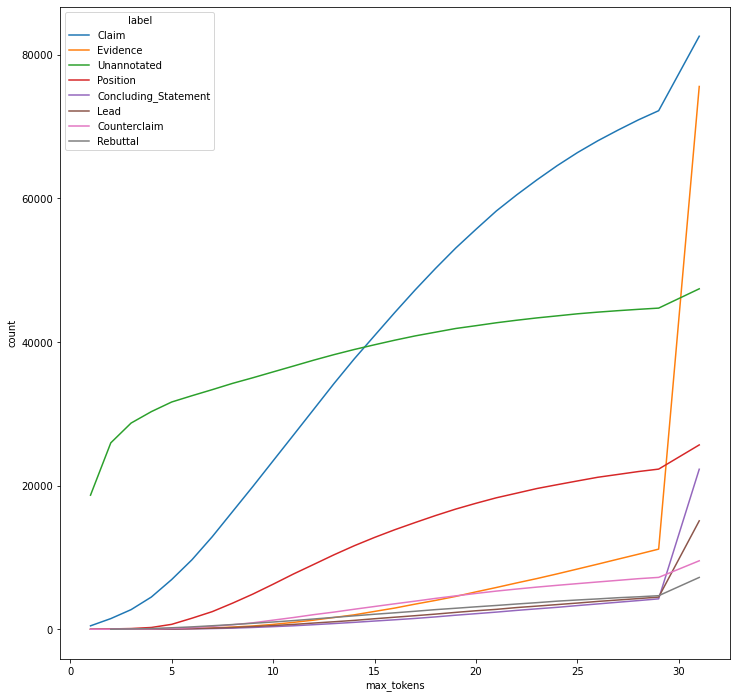

In [45]:
plt.rcParams["figure.figsize"] = (12,12)
ax = sns.lineplot(data=data_loss,x='max_tokens',y='count',hue='label')
# sns.lineplot(data_loss)

## Cleaning
Tried removing 2 and 10. 2 made little difference; 10 seemed overly aggressive.
Now removing anything with 5 or fewer words. This costs about 100,000 words and gives us more meaningful document vectors.

In [46]:
elements = discourse_types[discourse_types['text'].apply(len) > 5]
display(sum(discourse_types['text'].apply(len)))
display(sum(elements['text'].apply(len)))
display(elements)

10569558

10487146

,discourse_type,text
1,Lead,"[modern, human, today, be, always, on, their, ..."
2,Position,"[they, be, some, really, bad, consequence, whe..."
3,Evidence,"[some, certain, area, in, the, United, States,..."
4,Evidence,"[when, people, have, phone, they, know, about,..."
5,Claim,"[driving, be, one, of, the, way, how, to, get,..."
...,...,...
285377,Unannotated,"[next, it, can, change, your, perspective, on,..."
285378,Evidence,"[one, person, can, change, your, option, but, ..."
285379,Unannotated,"[finally, it, inform, you, about, what, other,..."
285380,Evidence,"[have, more, than, one, person, opinion, might..."


## Training

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(elements['text'], elements['discourse_type'], test_size=0.33, random_state=42)
# display(X_train.iloc[[99]])
# display(y_train.iloc[[99]])

# for ind, item in enumerate(X_train[:5].iteritems()):
#     print(item[0])
#     print(item[1])
#     print(y_train.iloc[ind])

In [56]:
def toks_to_tags(texts, labels):
    '''
    texts and labels must have matched indices
    '''
    for ind, text in enumerate(texts.iteritems()):
        yield(gensim.models.doc2vec.TaggedDocument(text[1], [str(text[0])]))
        # yield(gensim.models.doc2vec.TaggedDocument(text[1], [str(text[0]), labels.iloc[ind]]))

train_corpus = list(toks_to_tags(X_train, y_train))
test_corpus = list(toks_to_tags(X_test, y_test))

In [57]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=75, workers=4)
model.build_vocab(train_corpus)
print(f"The size of the model's vocabulary is {len(model.wv):,}.")
print(f"Word 'phone' appeared {model.wv.get_vecattr('phone', 'count')} times in the training corpus.")

The size of the model's vocabulary is 21,299.
Word 'phone' appeared 19002 times in the training corpus.


In [58]:
st = tm()
model.train(train_corpus,
            total_examples=model.corpus_count,
            epochs=model.epochs)
print(datetime.timedelta(seconds=round(tm()-st)))

0:13:51


## Sanity checks

In [69]:
print('The number of computed word vectors is...', len(model.wv))
word_vectors = model.wv
print('The word vector for phone is...')
print(word_vectors['phone'])

diag_words = ['phone', 'election', 'help', 'believe', 'argue', 'car', 'drive']

def simmer(diag_words, num_results):
    print()
    for word in diag_words:
        print(f'Most similar words to {word}:')
        for sim_word, score in word_vectors.most_similar(positive=[word])[:num_results]:
            print(sim_word, round(score, 2), end=' -- ')
        print('\n')
        
simmer(diag_words, 4)

print('We also have paragraph or document vectors')
print('The word vector for discourse element 1 is..')
[print(word, end=' ') for word in X_train.iat[1]]
print()
print(model.dv[1])
print()

# print('We also have keyed vectors that are similar to document vectors but represent a label')
# print('The keyed vector for Claim is...')
# print(model.dv['Claim'])

The number of computed word vectors is... 21299
The word vector for phone is...
[ 0.9440264   1.843681   -0.2831421   0.60748595 -0.34179407  0.7007451
 -0.358797   -0.37417257 -1.2422585   0.59644216  3.108598    0.22268274
 -1.0530525  -2.3246953  -0.48684278  0.32009187  0.01501742  1.5047117
  1.0677439   1.5038415   1.3475753  -0.05590146 -1.1784378  -0.8798601
  0.05685527  0.18976839  0.4826308   1.3438097   2.4083922   0.04120188
  1.0743891  -1.1654581   0.11240643 -0.35979745 -1.0850812  -1.3420819
  0.62853634  0.8924146   1.0721027   1.3649665   1.3037443  -0.5018755
 -2.6010697   0.3215218   2.094011    0.85365975 -0.282152    0.3489436
 -2.1781473  -0.45274383  1.518478   -0.5565993   0.01365317  0.54092485
  1.5923052  -1.0499762   1.0016569   0.85064286  0.09075197 -2.7371936
 -0.8553061   1.846229    1.504581   -0.5167069   1.2849907   1.5717323
 -0.37174362  2.2149372  -0.6945535  -1.9493749  -0.48622608  0.5315689
  1.6906598  -1.8698798   0.7340799  -1.6570753   0.5

## Modelling

In [60]:
# for text in test_corpus[:5]:
#     print(y_test.iloc[int(text.tags)])
#     print(text.tags)
#     print(X_test.iloc[int(text.tags)])

# def diagnosticator(test_corpus, X_train, y_train, debug=False):
#     y_pred = []
#     y_true = []
#     for doc in test_corpus:
#         idx = int(doc.tags[0])
#         inferred_vector = model.infer_vector(doc.words)
#         sims = model.dv.similar_by_vector(inferred_vector, topn=9)

#         # pred = int(sims[0][0]) if sims[0][0].isdigit() else sims[0][0]
#         pred = next(int(pred[0]) for pred in sims if pred[0].isdigit())
#         print(sims)
#         print(pred)
# #         if debug:
# #             print(f'True: {doc.tags[1]}')
# #             print('Unseen text:', end='  ')
# #             [print(word, end=' ') for word in doc.words]
# #             print()
# #         if type(pred) == int:
# #             pred_label = y_train.at[pred]
# #             if debug:
# #                 print('Most similar text:', end='  ')
# #                 [print(word, end=' ') for word in X_train[pred]]
# #                 print()
# #                 print(f'Predicted: {pred_label}')
# #                 print('---')
# #         elif type(pred) == str:
# #             pred_label = pred
# #             if debug:
# #                 print(f'Most similar to keyed vector: {pred}')
# #                 print('---')

# #         y_true.append(doc.tags[1])
#         # y_pred.append(pred_label)
# #         second_ranks.append(sims[1])
#     return y_true, y_pred

In [70]:
def diagnosticator(X_test, y_test, X_train, y_train, debug=False):
    y_pred = []
    y_true = []
    for ind, doc in tqdm(X_test.iteritems(), total=len(X_test)):
        inferred_vector = model.infer_vector(doc)
        pred = int(model.dv.similar_by_vector(inferred_vector, topn=1)[0][0])
        if debug:
            print(f'True: {y_test.at[ind]}')
            print('Unseen text:', end='  ')
            [print(word, end=' ') for word in doc]
            print()
        if type(pred) == int:
            pred_label = y_train.at[pred]
            if debug:
                print('Most similar text:', end='  ')
                [print(word, end=' ') for word in X_train[pred]]
                print()
                print(f'Predicted: {pred_label}')
                print('---')
        elif type(pred) == str:
            pred_label = pred
            if debug:
                print(f'Most similar to keyed vector: {pred}')
                print('---')

        y_true.append(y_test.at[ind])
        y_pred.append(pred_label)
    return y_true, y_pred

In [71]:
x, y = diagnosticator(X_test=X_test[:5],
                      y_test=y_test,
                      X_train=X_train,
                      y_train=y_train,
                      debug=True)

100%|██████████| 5/5 [00:00<00:00, 76.39it/s]

True: Evidence
Unseen text:  because people such as Carlos Arturo have use the limitation as an opportunity to take away or Vauban Heidran Walter who just feel less tense and much not only will these limitation positively effect city but positively effect the overall mood of the people too 
Most similar text:  in Germany there be certain community that ban car usage no car be allow inside the city street parking driveway and home garage have become obsolete one citizen of one of the town say when I have a car I be always tense I much happy this way in german suburb the anxiety one get when drive a car be almost unreal Most kid and up now just do not get their license just because the thought of drive scare they citizen of city that have just one day where care be prohibit such as Bogota Colombia love that singular day out of the year Most say it a good opportunity to increase mental health car free day be spin into a big hit in Bogota stress not only be awful for mental health but also

In [63]:
# labels = ['Claim', 'Evidence', 'Unannotated', 'Position', 'Concluding Statement',
#        'Lead', 'Counterclaim', 'Rebuttal']
# for label in labels:
#     print(model.dv.get_index(label, default=None))

In [65]:
# def diagnosticator(texts):
#     y_pred = []
#     y_true = []
# #     second_ranks = []
#     for text in texts:
#         label = text.tags[0]
#         inferred_vector = model.infer_vector(text.words)
#         sims = model.dv.most_similar([inferred_vector], topn=1)
# #         sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
#         pred = sims[0][0]
# #         pred = [docid for docid, sim in sims].index(label)
#         y_true.append(label)
#         y_pred.append(pred)
# #         second_ranks.append(sims[1])
#     return y_true, y_pred

In [74]:
y_true, y_pred = diagnosticator(X_test=X_test[:1000],
                                y_test=y_test,
                                X_train=X_train,
                                y_train=y_train)

100%|██████████| 1000/1000 [00:06<00:00, 143.07it/s]


                      precision    recall  f1-score   support

               Claim       0.46      0.58      0.52       322
Concluding Statement       0.17      0.11      0.13        82
        Counterclaim       0.31      0.24      0.27        51
            Evidence       0.57      0.43      0.49       287
                Lead       0.17      0.15      0.16        53
            Position       0.38      0.44      0.41       112
            Rebuttal       0.14      0.20      0.17        25
         Unannotated       0.17      0.19      0.18        68

            accuracy                           0.41      1000
           macro avg       0.30      0.29      0.29      1000
        weighted avg       0.41      0.41      0.40      1000



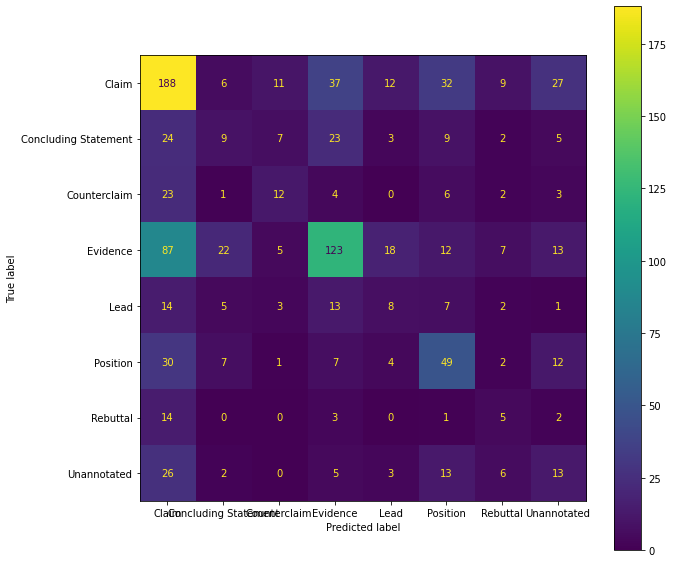

In [74]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, NuSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

print(classification_report(y_true, y_pred))
plt.rcParams["figure.figsize"] = (17,15)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()

In [73]:
# X_train_log = np.array([model.dv[i] for i in range(len(model.dv))])
def vector_retrieval(model, labels, input_docs):
    targets, feature_vectors = zip(*[(labels.at[int(doc.tags[0])], model[doc.tags[0]]) for doc in input_docs])
    return targets, feature_vectors
def vector_inference(model, labels, input_docs):
    targets, feature_vectors = zip(*[(labels.at[int(doc.tags[0])], model.infer_vector(doc.words, steps=20)) for doc in input_docs])
    return targets, feature_vectors

y_cls_train, X_cls_train = vector_retrieval(model, y_train, tqdm(train_corpus))
y_cls_test, X_cls_test = vector_inference(model, y_test, tqdm(test_corpus))

100%|██████████| 81079/81079 [04:41<00:00, 287.63it/s]


Random Forest Classifier
                      precision    recall  f1-score   support

               Claim       0.50      0.65      0.57     25057
Concluding Statement       0.50      0.02      0.04      7294
        Counterclaim       0.93      0.00      0.01      3071
            Evidence       0.48      0.90      0.62     25082
                Lead       0.88      0.00      0.00      4889
            Position       0.84      0.09      0.16      8126
            Rebuttal       1.00      0.00      0.00      2324
         Unannotated       0.57      0.00      0.00      5236

            accuracy                           0.49     81079
           macro avg       0.71      0.21      0.18     81079
        weighted avg       0.59      0.49      0.39     81079

0:03:46


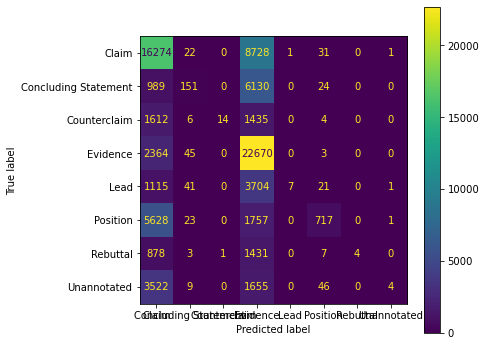

Linear Discriminant Analysis
                      precision    recall  f1-score   support

               Claim       0.51      0.56      0.53     25057
Concluding Statement       0.26      0.60      0.37      7294
        Counterclaim       0.29      0.07      0.11      3071
            Evidence       0.52      0.64      0.57     25082
                Lead       0.37      0.25      0.30      4889
            Position       0.41      0.04      0.07      8126
            Rebuttal       0.16      0.06      0.08      2324
         Unannotated       0.14      0.00      0.01      5236

            accuracy                           0.45     81079
           macro avg       0.33      0.28      0.25     81079
        weighted avg       0.43      0.45      0.41     81079

0:00:03


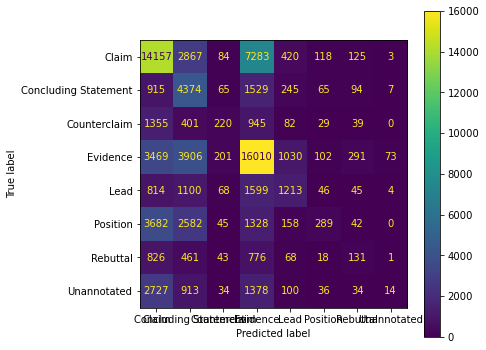

LinearSVC


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


                      precision    recall  f1-score   support

               Claim       0.49      0.58      0.53     25057
Concluding Statement       0.31      0.47      0.37      7294
        Counterclaim       0.27      0.01      0.01      3071
            Evidence       0.48      0.74      0.59     25082
                Lead       0.47      0.09      0.16      4889
            Position       0.32      0.02      0.03      8126
            Rebuttal       0.00      0.00      0.00      2324
         Unannotated       0.09      0.00      0.00      5236

            accuracy                           0.46     81079
           macro avg       0.30      0.24      0.21     81079
        weighted avg       0.40      0.46      0.39     81079

0:09:28


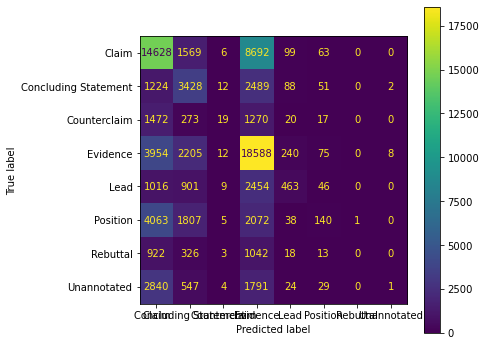

AdaBoost Classifier
                      precision    recall  f1-score   support

               Claim       0.45      0.72      0.56     25057
Concluding Statement       0.34      0.16      0.22      7294
        Counterclaim       0.32      0.01      0.03      3071
            Evidence       0.51      0.75      0.61     25082
                Lead       0.32      0.02      0.04      4889
            Position       0.41      0.03      0.06      8126
            Rebuttal       0.29      0.00      0.01      2324
         Unannotated       0.00      0.00      0.00      5236

            accuracy                           0.47     81079
           macro avg       0.33      0.21      0.19     81079
        weighted avg       0.41      0.47      0.39     81079

0:01:41


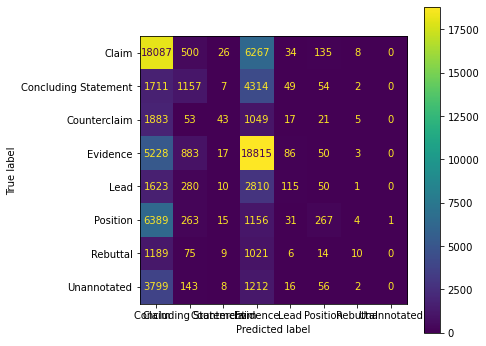

In [78]:
plt.rcParams["figure.figsize"] = (10,10)

dict_of_classifiers = {#"3-Neighbors Classifier":KNeighborsClassifier(n_neighbors=3),
                       "Random Forest Classifier": RandomForestClassifier(),
                       "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
                       "LinearSVC": LinearSVC(),
                       "AdaBoost Classifier": AdaBoostClassifier(),
                        }

for name, classifier in dict_of_classifiers.items():
    print(name)
    st = tm()
    classifier.fit(X_cls_train, y_cls_train)
    y_cls_pred = classifier.predict(X_cls_test)
    print(classification_report(y_cls_test, y_cls_pred))
    print(datetime.timedelta(seconds=round(tm()-st)))
    ConfusionMatrixDisplay.from_predictions(y_cls_test, y_cls_pred)
    plt.show()